### Finding Optimal Shared Streets Code Tutorial
#### Coauthors
#### Emma Gibbs,  MIchael Schmidt, Evan Shapiro

This is a tutorial that is complimentary to our project for finding optimal streets in Denver to convert into Shared Streets. We attempted to identify Denver neighborhoods that will benefit most from an improved walking and biking experience by using equity scores and pedestrian demand index scores accessed throught the Denver Open Data Catalog.  
We define optimal streets to be the streets in a neighborhood that on average, when removed, have the least impact on traffic flow in the surrounding area. Please refer to our project slides for how we define equitable, and choose neighborhoods in an equitable manner.  




# Tutorial Outline:   
- Import all data necessary for identifying neighborhoods of interest based on neighborhood equity data, pedestrian demand index Data, traffic accident data, and key destination data from the Denver Open Data Catalog.
- Use the above data to identify candidate neighborhoods and streets.
- Using "" method, assign traffic flow capacities to the candidate streets for analysis.    
- Run the All Pairs Max-Flow algorithm in Networkxto identify which of the candidate streets, on average, have the lowest impact on traffic flow when removed from the street network.  

### Tutorial Requirements:
- To run this Jupyter notebook tutorial you need to have Python 3.-, Jupyter Notebook, NetworkX, Geopandas, and OSMnx installed on your computer.  

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as line
import osmnx as ox
from shapely.ops import unary_union
#import util

### Neighborhood and Street Selection
Please refer to the <a href=https://github.com/schmidmt/Finding-Optional-Shared-Streets/blob/main/notebooks/BestNeighborhoodsStreets.ipynb>Best Neighborhoods Shared Streets ,</a> Jupyter Notebook for this part of the tutorial.

To choose candidate neighborhoods and streets we consider [Boulder's Low-Stress Walk and Bike Network Plan,](https://bouldercolorado.gov/projects/low-stress-walk-and-bike-network-plan) by [this paper:](https://bouldercolorado.gov/media/4530/download?inline=)

On page 34, the paper indicates that roads are chosen based on the following criteria:
* Equity index; areas with a lower equity index are valued more. Here is [Denver's equity index data.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-equity-index-2020-neighborhood)
* Population and employment density; higher density neighborhoods are valued more.
  * Population and employment density are considered as part of the [Pedestrian Demand Index.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-pedestrian-demand-index)
* Density of crashes; more heavily weighted for pedestrian or bicyclist-involved crashes. Here is [Denver's crash data.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-traffic-accidents)
* Key destinations; the paper specifies parks, schools, and high-frequency transit stops, though it also indicates libraries, fitness centers, trailheads, restaurants, cafes, and grocery stores.
  * [Here](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-parks) is park data, [here](https://mygeodata.cloud/data/download/osm/schools/united-states-of-america--colorado/denver-county/denver) is school data, and [here](https://gis-rtd-denver.opendata.arcgis.com/maps/e14366d810644a3c95a4f3770799bd54/about) is RTD transit stop data.

Neighborhood Equity Data and Pedestrian Demand Index Data are imported from the Denver Open Data Catalog. This data is used to determine neighborhoods that have both low equity index scores, and high pedestrian demand index scores.  
   


# Neighborhood Selection

## Storing Equity Data

In [5]:
equity_data = gpd.read_file("../data/equity_index_2020___neighborhood.gdb", driver="OpenFileGDB")
equity_data.head()

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,SHAPE_Length,SHAPE_Area,geometry
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339..."
1,Harvey Park,2.0,2.5,2.0,3.0,1.5,2.2,0.105342,0.000458,"MULTIPOLYGON (((-105.02511 39.66772, -105.0260..."
2,Mar Lee,2.0,1.5,2.5,2.0,3.5,2.3,0.085462,0.000410,"MULTIPOLYGON (((-105.02506 39.69675, -105.0250..."
3,East Colfax,1.5,1.5,3.5,1.0,2.0,1.9,0.073874,0.000291,"MULTIPOLYGON (((-104.88466 39.74746, -104.8846..."
4,Capitol Hill,4.0,2.5,4.0,1.0,4.0,3.1,0.054472,0.000184,"MULTIPOLYGON (((-104.97341 39.74003, -104.9729..."


Plotting Neighborhoods by Equity Index Score
    

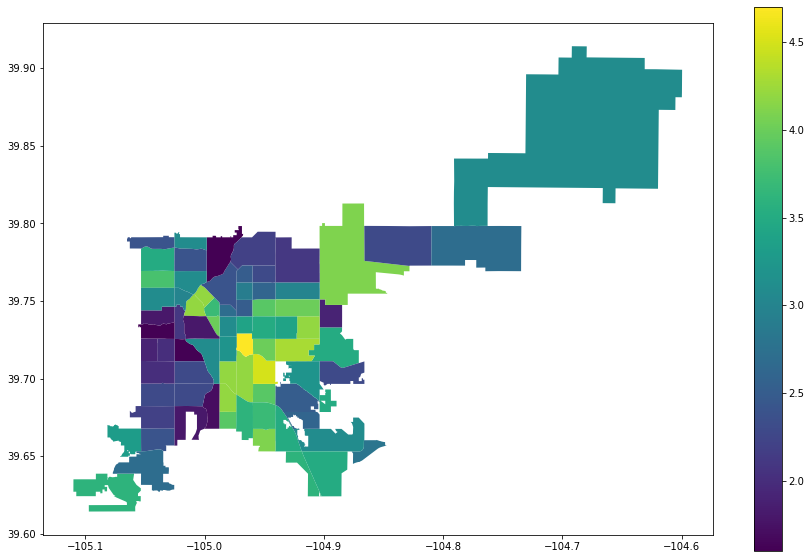

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="OVERALLEQUITY_SCORE", ax=ax, legend=True);

## Pedestrian Demand Data 

Storing pedestrian demand data.

In [7]:
pedestrian_data = gpd.read_file("../data/pedestrian_demand_index.gdb", driver="OpenFileGDB")
pedestrian_data.head()

,GEOID10,PDI_Score,PDI_Ranking,SHAPE_Length,SHAPE_Area,geometry
0,0803100412146,10,HIGH,0.005259,0.000002,"MULTIPOLYGON (((-104.99272 39.74744, -104.9929..."
1,0803100409310,8,HIGH,0.033493,0.000064,"MULTIPOLYGON (((-104.95938 39.66789, -104.9593..."
2,0803100410310,1,LOW,0.031635,0.000046,"MULTIPOLYGON (((-104.85573 39.66044, -104.8556..."
3,0803100407030,8,HIGH,0.040299,0.000073,"MULTIPOLYGON (((-104.89524 39.73595, -104.8952..."
4,0803100410130,8,HIGH,0.039525,0.000073,"MULTIPOLYGON (((-104.91274 39.67846, -104.9127..."


Plotting neighborhoods by pedestrian demand index score.

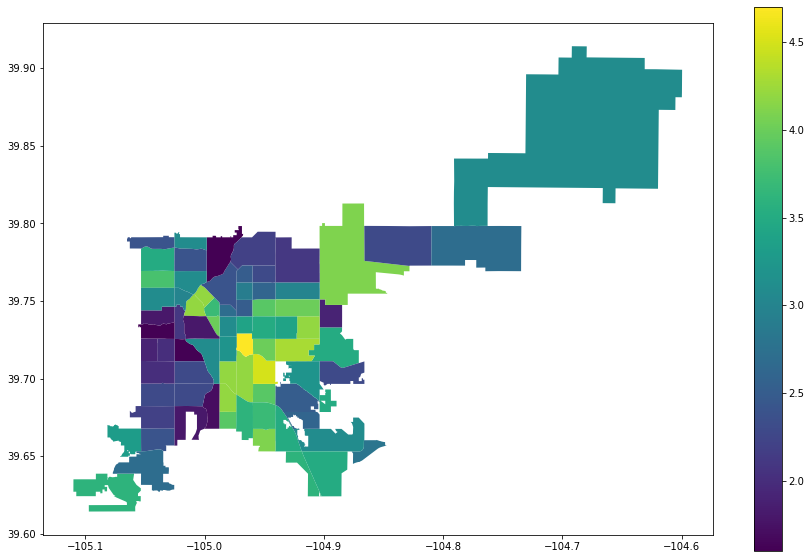

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="OVERALLEQUITY_SCORE", ax=ax, legend=True);

## Merging Pedestrian Demand Data and Equity Index Data

Pedestrian Demand Index Scores (PDI) are available over smaller geographic areas than the Equity Scores, so the average PDI is calculated over a a region with a single equity. When choosing neighborhoods for analysis, we are interested in finding neighborhoods with both a low Equity Score and high PDI scores. Both scores are scaled to be between 0 and 10, and then the absolute difference of the two scores  is calculated.  


We call this score the Pedestrian Equity Difference Score.  

Pedestrian-Equity Difference Score = $$|PDI_{10} - EI_{10}|$$ 
  
Future work may reweight the PDI or Equity Index in a weighted average to assign different, possibly negative weights to the Equity Index or PDI.

Adding column "EQUITY_SCORE_10" to data frame, scaling overall equity score so that its max value is 10.

In [12]:
equity_score_10 = equity_data["OVERALLEQUITY_SCORE"]
equity_score_10 = (equity_score_10 / max(equity_score_10)) * 10
equity_data.insert(7, "EQUITY_SCORE_10", equity_score_10, False)

Merging equity data and pedestrian data. This merge uses predicate "intersects," so some pedestrian data entries may be counted multiple times if they intersect with multiple equity data entries.

In [13]:
equity_ped_data = equity_data.sjoin(pedestrian_data)
equity_ped_data.head()

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,SHAPE_Length_left,SHAPE_Area_left,geometry,index_right,GEOID10,PDI_Score,PDI_Ranking,SHAPE_Length_right,SHAPE_Area_right
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339...",139,0803100411020,3,LOW,0.06106,0.000150
62,Southmoor Park,4.0,4.5,3.0,5.0,1.5,3.6,7.659575,0.107831,0.000253,"MULTIPOLYGON (((-104.90186 39.62409, -104.9040...",139,0803100411020,3,LOW,0.06106,0.000150
63,Hampden South,4.5,4.0,2.5,4.0,2.5,3.5,7.446809,0.120254,0.000791,"MULTIPOLYGON (((-104.90205 39.62443, -104.9023...",139,0803100411020,3,LOW,0.06106,0.000150
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339...",309,0803100411030,7,HIGH,0.05323,0.000083
61,Hampden,3.0,3.0,3.0,4.0,2.5,3.1,6.595745,0.200578,0.000768,"MULTIPOLYGON (((-104.86602 39.66027, -104.8663...",309,0803100411030,7,HIGH,0.05323,0.000083


* Since "pedestrian_data" is spatially subdivided more than "equity_data", the following code finds the average "PDI_Score" for each neighborhood in "equity_data," storing those values in "AVG_PDI_SCORE." 
* It then scales those averages so their max value is 10, storing those values in "AVG_PDI_10." 
* Finally it takes the difference of "AVG_PDI_10" and "EQUITY_SCORE_10" for each neighborhood, and stores those values in "PDI_EQUITY_DIFF." I.e., higher PDI scores and lower equity scores are more desirable, lower PDI scores and higher equity scores are less desirable. 
* Additionally, since PDI and Equity are both scaled to have max values of 10, they are weighed equally in consideration.

In [14]:
nbrhd_count = [0] * len(equity_data)
nbrhd_total = [0] * len(equity_data)

#kind of inefficient, but finding average PDI score for smaller neighborhoods
#in each larger neighborhood
for i in range(len(equity_ped_data)):
  for j in range(len(equity_data)):
    if (equity_ped_data.iat[i,0] == equity_data.iat[j,0]):
      nbrhd_count[j] += 1
      nbrhd_total[j] += equity_ped_data.iat[i,13]

In [15]:
AVG_PDI_SCORE = [0] * len(equity_data)

#storing average PDI score for each neighborhood in equity_data
for i in range(len(equity_data)):
  AVG_PDI_SCORE[i] = nbrhd_total[i] / nbrhd_count[i]

#scaling AVG_PDI_SCORe by 10
AVG_PDI_10 = (AVG_PDI_SCORE / max(AVG_PDI_SCORE)) * 10

#finding difference between pedestrian demand and equity
PDI_EQUITY_DIFF = AVG_PDI_10 - equity_score_10

#adding all three new variables to equity_data
equity_data.insert(8, "AVG_PDI_SCORE", AVG_PDI_SCORE, False)
equity_data.insert(9, "AVG_PDI_10", AVG_PDI_10, False)
equity_data.insert(10, "PDI_EQUITY_DIFF", PDI_EQUITY_DIFF, False)

equity_data.head()

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area,geometry
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,4.428571,4.942169,-2.504639,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339..."
1,Harvey Park,2.0,2.5,2.0,3.0,1.5,2.2,4.680851,3.500000,3.905908,-0.774943,0.105342,0.000458,"MULTIPOLYGON (((-105.02511 39.66772, -105.0260..."
2,Mar Lee,2.0,1.5,2.5,2.0,3.5,2.3,4.893617,4.933333,5.505470,0.611853,0.085462,0.000410,"MULTIPOLYGON (((-105.02506 39.69675, -105.0250..."
3,East Colfax,1.5,1.5,3.5,1.0,2.0,1.9,4.042553,3.083333,3.440919,-0.601634,0.073874,0.000291,"MULTIPOLYGON (((-104.88466 39.74746, -104.8846..."
4,Capitol Hill,4.0,2.5,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184,"MULTIPOLYGON (((-104.97341 39.74003, -104.9729..."


Plotting neighborhoods by "PDI_EQUITY_DIFF."

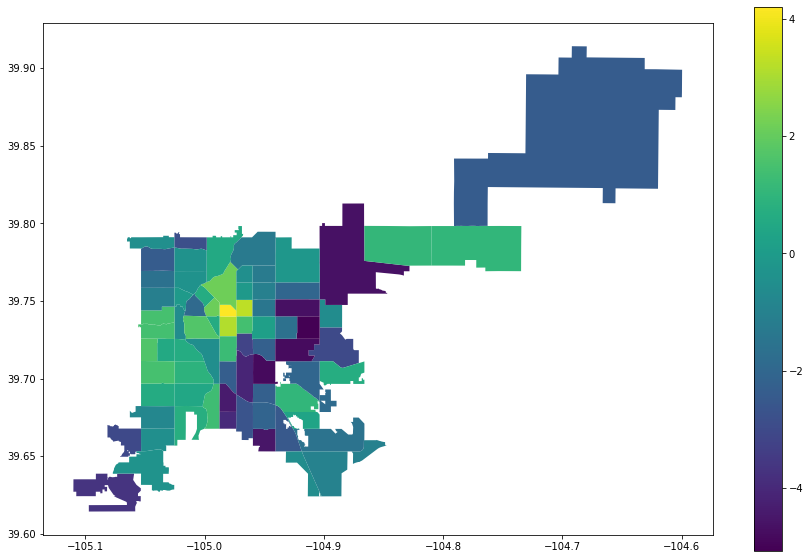

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="PDI_EQUITY_DIFF", ax=ax, legend=True);

The 5 neighborhoods we identified with the Pedestrian-Equity Difference Score are
- North Capitol Hill
- City Park West
- Capitol Hill
- Five Points
- Central Business District


In [ ]:
We focus on the North Capitol Hill Neighborhood for the rest of the tutorial.

In [22]:
nbrhds_of_interest = equity_data.sort_values(by = ["PDI_EQUITY_DIFF"], ascending = False)[0:1]
nbrhds_of_interest.head()

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area,geometry
5,North Capitol Hill,3.0,2.0,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096,"MULTIPOLYGON (((-104.97338 39.74378, -104.9733..."


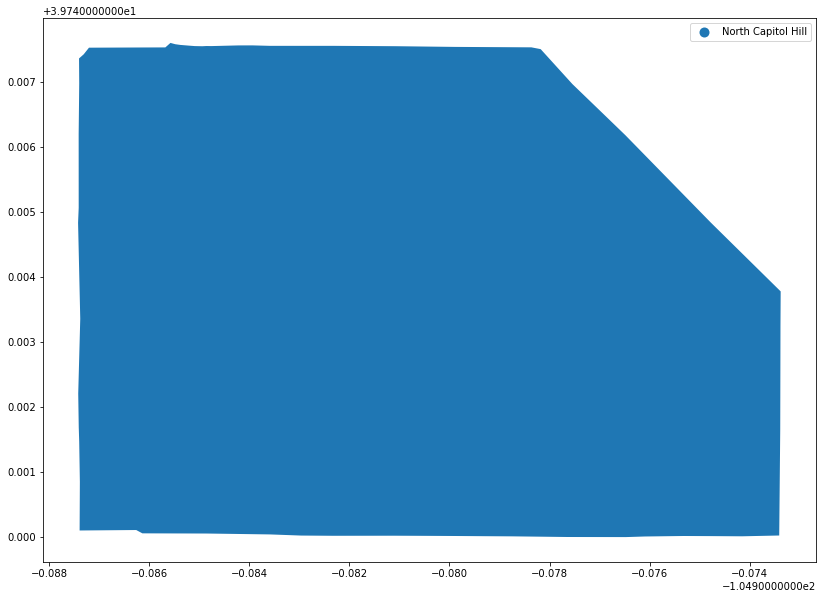

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, legend=True);

# Street Selection

Now that we have identified our candidate neighborhoods, candidate streets for conversion to shared access are identified within these neighborhoods. We pick streets based upon:
- Crash Data
- Key Destination Data
- Transit Stop Data

Neighborhoods and streets with a higher number of car accidents are prioritized for conversion to Shared Street in order to improve pedestrian and biking experience . When considering accident data we created a 400m buffer around crash site data. This allowed us capture areas that have a high concentration of traffic accidents in our analysis.  
The key neighborhood destinations that we considered are schools and parks, prioritizing neighborhoods with more schools and parks . You are welcome to modify or add different key destinations, like restaurants, hospitals or libraries, in your analysis.


## Crash Data  
Storing Crash Data

In [24]:
crash_data = gpd.read_file("../data/traffic_accidents.gdb", driver="OpenFileGDB")
crash_data.head()

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,geometry
0,1.0,2017100002,201710000254410,5441,0,TRAF - ACCIDENT,I70 HWYEB / N NORTHFIELD QUEBEC ST,3167637.0,1708927.0,-104.903568,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.90357 39.77830)
1,2.0,2017100074,201710007454410,5441,0,TRAF - ACCIDENT,3200 N BRIGHTON BLVD,3145663.0,1704934.0,-104.981828,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.98183 39.76771)
2,3.0,2017100083,201710008354410,5441,0,TRAF - ACCIDENT,I70 HWYEB / I270 HWYWB,3174254.0,1708511.0,-104.880037,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.88004 39.77704)
3,4.0,2017100084,201710008454410,5441,0,TRAF - ACCIDENT,W 1ST AVENUE / N VRAIN STREET,NaN,NaN,NaN,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None
4,5.0,2017100117,201710011754010,5401,0,TRAF - ACCIDENT - HIT & RUN,S PLATTE RIVER DR / W TENNESSEE AVE,3142747.0,1679702.0,-104.992702,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.99270 39.69849)


Subsetting crash data by pedestrian-involved, bicyclist-involved, or involving serious injury or death.

In [25]:
crash_data = crash_data[(crash_data["BICYCLE_IND"] > 0) | (crash_data["PEDESTRIAN_IND"] > 0) | (crash_data["SERIOUSLY_INJURED"] > 0) | (crash_data["FATALITIES"] > 0)]
crash_data.head()

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,geometry
44,45.0,2017101418,201710141854411,5441,1,TRAF - ACCIDENT - SBI,2600 BLOCK S MONACO ST,3165327.0,1669042.0,-104.912704,...,OTHER,OTHER,OTHER,1.0,0.0,OTHER,OTHER,PEDESTRIAN,OTHER,POINT (-104.91270 39.66885)
51,52.0,2017102174,201710217454410,5441,0,TRAF - ACCIDENT,3550 S KENDALL ST,3122263.0,1662642.0,-105.065788,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-105.06579 39.65195)
67,68.0,2017102725,201710272554410,5441,0,TRAF - ACCIDENT,I70 HWYWB / N BRIGHTON BLVD,3149779.0,1709487.0,-104.967092,...,00,NO APPARENT,OTHER,1.0,0.0,OTHER,OTHER,PASSENGER CAR/VAN,OTHER,POINT (-104.96709 39.78014)
75,76.0,2017102901,201710290154411,5441,1,TRAF - ACCIDENT - SBI,4300 BLOCK W FLORIDA AVE,3128406.0,1676323.0,-105.043727,...,OTHER,OTHER,CROSS/ENTER AT INTERSECTION,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-105.04373 39.68942)
82,83.0,2017103278,201710327854010,5401,0,TRAF - ACCIDENT - HIT & RUN,1600 BLOCK 17TH ST,3140799.0,1699264.0,-104.999242,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.99924 39.75222)


Subsetting "crash_data" by intersecting with "nbrhds_of_interest," which is North Capitol Hill. 

In [26]:
crash_data = crash_data.sjoin(nbrhds_of_interest)
crash_data.head()

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area
1920,1921.0,2017173499,201717349954010,5401,0,TRAF - ACCIDENT - HIT & RUN,N LINCOLN ST / E 16TH AVE,3144511.0,1695445.0,-104.986117,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
2579,2580.0,2017194401,201719440154010,5401,0,TRAF - ACCIDENT - HIT & RUN,E 16TH AVE / N LOGAN ST,3145575.0,1695450.0,-104.982334,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
3071,3072.0,201721070,20172107054410,5441,0,TRAF - ACCIDENT,PARK AVE / N DOWNING ST,3148087.0,1696230.0,-104.973385,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
4457,4458.0,2017256365,201725636554410,5441,0,TRAF - ACCIDENT,E 16TH AVE / N SHERMAN ST,3144866.0,1695446.0,-104.984855,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
5264,5265.0,2017282407,201728240754410,5441,0,TRAF - ACCIDENT,E 16TH AVE / N PENNSYLVANIA ST,3145925.0,1695452.0,-104.981089,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Plotting crash data within North Capitol Hill

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


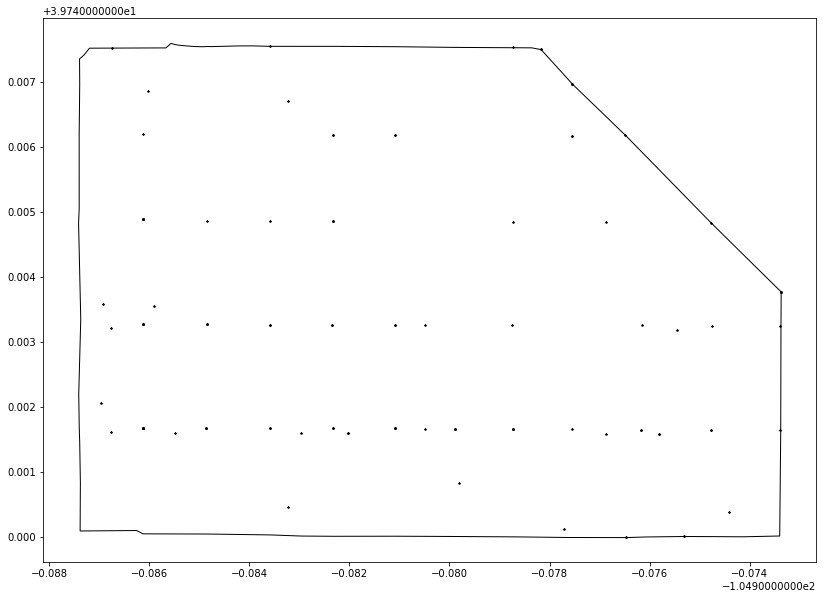

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
crash_data.plot(ax = base, marker = "*", color = "black", markersize = 3);

## Key Destinations  
### Park Data

Storing park data

In [29]:
park_data = gpd.read_file("../data/parks.gdb", driver="OpenFileGDB")
park_data.head()

,LOCATION,FORMAL_NAME,LOC_CODE,PARK_TYPE,PARK_CLASS,GIS_ACRES,DESIGNATED,FIRST_AQ_DATE,MASTER_PLAN,MAINT_DIST,...,LONGITUDE,MARKETING_CODE,FACILITIES,DIAGRAM,PHOTO,PARCEL_MATCH,BND_QC,SHAPE_Length,SHAPE_Area,geometry
0,Verbena,Verbena Park,L18,Park,Neighborhood,7.185635,Yes,1969,None,NE,...,-104.891271,PK,"Picnic Shelter, Picnic Tables, Benches, Playgr...",ParkArt_Verbena Park.pdf,verbenapark.jpg,Yes,2015-09-09T00:00:00+00:00,0.007571,0.000003,"MULTIPOLYGON (((-104.89070 39.73294, -104.8918..."
1,Legault Mountain,Legault Mountain Tracts,M30,Conservation Tract,Mountain,134.790235,Yes,1924,2008,MP,...,-105.245073,None,"Scenic View Shed, Natural Open Space",,no_imagerec.gif,None,2010-05-14T00:00:00+00:00,0.053131,0.000057,"MULTIPOLYGON (((-105.24317 39.53059, -105.2431..."
2,Hobbs Peak,Hobbs Peak Tract,M29,Conservation Tract,Mountain,38.849537,Yes,1925,2008,MP,...,-105.302888,None,"Scenic View Shed, Natural Open Space",,no_imagerec.gif,None,2010-05-21T00:00:00+00:00,0.016372,0.000016,"MULTIPOLYGON (((-105.30059 39.59120, -105.3012..."
3,City of Takayama,City of Takayama Park,331,Park,Linear,6.060320,Yes,1966,None,E,...,-104.943746,PK,"Benches, Bike/Pedestrian Path, Cherry Creek Trail",ParkArt_City of Takayama Park.pdf,takayamapark.jpg,No,2009-09-30T00:00:00+00:00,0.016074,0.000003,"MULTIPOLYGON (((-104.94715 39.71108, -104.9464..."
4,Highline Canal (Parker to Havana),Highline Canal (Parker to Havana),661,Park,Linear,28.792370,Not Eligible,N/A - DW (1980s),N/A,NE,...,-104.884899,None,"Bike/Pedestrian Path, High Line Canal Trail, O...",ParkArt_Highline Canal.pdf,no_imagerec.gif,Yes,2009-06-08T00:00:00+00:00,0.085017,0.000012,"MULTIPOLYGON (((-104.89017 39.70461, -104.8901..."


Subsetting park data by intersecting with neighborhood of interest, North Capitol Hill.

In [31]:
park_data = park_data.sjoin(nbrhds_of_interest)
park_data.head()

,LOCATION,FORMAL_NAME,LOC_CODE,PARK_TYPE,PARK_CLASS,GIS_ACRES,DESIGNATED,FIRST_AQ_DATE,MASTER_PLAN,MAINT_DIST,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length_right,SHAPE_Area_right
196,Park Ave Parks,Park Ave Parks,317,Park,Neighborhood,2.724734,Yes - 1956,1874,None,E,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Plotting parks within North Capitol Hill.

C:\Users\Evan Shapiro\Documents\Python\envs\ox\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


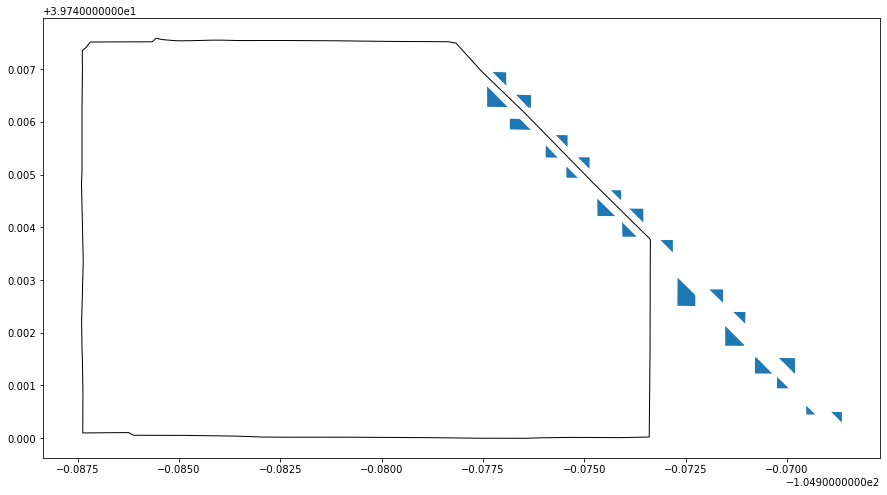

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
park_data.plot(ax = base);

The 5 streets identified in the North Capitol Hill Neighborhood were:  
Street 1  
East 18th Avenue  
Street 2  
Pennsylvania Street  
Street 3  
East 19th Avenue  
Street 4  
East 19th Avenue  
Street 5  
Pennsylvania Street  

### Finding Optimal Shared Streets
